<a href="https://colab.research.google.com/github/MBalogogGLemuel/MBalogogGLemuel.github.io/blob/main/Exploration_Model_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import joblib


from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

Fonction du f1_score

In [2]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Sliding window ML

In [3]:
# fonction pour creer la sliding windows

def slide_window(dataset, window_size=7):
    oc1, oc2, oc3, p1, p2, p3, pt01, pt02, pt03 , ptn01, ptn02, ptn03 , pt11, pt22, ptn33 , ptn11, ptn22, ptn33 ,cl1, cl2, cl3 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    y1 = []

    X, y = [], []
    input ,output =[], []

    # Trouver toutes les sequences de 'window_size' donnees, dans le dataset,
    # ainsi que leur 'y' (target)
    for i in range( dataset.shape[0] - window_size ):
        X = dataset.iloc[ i : i + window_size, : ] 
        y = dataset.iloc[i + window_size, 5] 

        oc1 = X.iloc[0,0], 
        oc2 = X.iloc[1,0], 
        oc3 = X.iloc[2,0], 
        p1 = X.iloc[0,1], 
        p2 = X.iloc[1,1], 
        p3 = X.iloc[2,1], 
        pt01 = X.iloc[0,3], 
        pt02 = X.iloc[1,3], 
        pt03 = X.iloc[2,3],
        pt11 = X.iloc[0,4], 
        pt22 = X.iloc[1,4], 
        pt33 = X.iloc[2,4],
        cl1 = X.iloc[0,5], 
        cl2 = X.iloc[1,5], 
        cl3 = X.iloc[2,5],
        y1 = y

        input.append( [[oc1, oc2, oc3, p1, p2, p3, pt01, pt02, pt03 ,pt11, pt22, pt33 ,cl1, cl2, cl3 ]] )
        output.append( y1 )


    return np.asarray(input).astype(np.float32) , np.asarray(output).astype(np.float32)

Stateful

In [4]:
class StatefulScaler():
    def __init__(self, epsilon, initial_mean = 0): # e.g. epsilons: {1: 0.1, 2: 0.9}
        self.epsilon = epsilon
        self.stateful_mean = initial_mean
        self.data_mean = initial_mean

    def normalize(self, fenetre, update_mean = True):

        if update_mean:
            self.stateful_mean = (1-self.epsilon) * self.stateful_mean + (self.data_mean * self.epsilon)
        
        factor = (self.stateful_mean-self.data_mean) / (self.data_mean + 1e-7)
        fenetre_norm = (fenetre - fenetre.min()) / ((fenetre.max() - fenetre.min()) + 1e-7) # Ajouter 1e-7 a la moyenne pour éviter la division par 0
        fenetre_norm = fenetre_norm * factor
        
        return fenetre_norm

    def normalize_window(self, window):
        fenetre_norm = np.asarray([self.normalize(window[i]) for i in range(window.shape[0])]).astype(np.float32)
        return fenetre_norm

    def reset_stateful_mean(self):
        self.stateful_mean = self.data_mean

In [5]:
# pour le modele de DML

class Generateur(tf.keras.utils.Sequence):

    def __init__(self, dataset, batch_size=8, window_size=3):

        self.X , self.y = dataset.drop('class_state', axis=1).to_numpy().astype(np.float32), np.asarray(tf.one_hot(dataset['class_state'], depth=5)).astype(np.float32)
        
        self.batch_size = batch_size
        self.window_size = window_size

        self.t_scaler = StatefulScaler(0.75, np.mean(self.X[:, 1]))
        self.t_fwd_scaler = StatefulScaler(0.9, np.mean(abs(self.X[:, 2])))
        self.t_back_scaler = StatefulScaler(0.9, np.mean(abs(self.X[:, 3])))
        
    def on_epoch_end(self):
        # Reset Stateful mean to dataset mean
        self.t_scaler.reset_stateful_mean()
        self.t_fwd_scaler.reset_stateful_mean()
        self.t_back_scaler.reset_stateful_mean()
        
    def __len__(self):
        return (self.X.shape[0] - self.window_size + 1) // self.batch_size

    def __getitem__(self, idx):

        batch_x = self.X[ (idx * self.batch_size) : (idx + 1) * self.batch_size + self.window_size - 1, : ]
        batch_y = self.y[ (idx * self.batch_size) : (idx + 1) * self.batch_size + self.window_size - 1, : ]

        batch_x, batch_y = self.slide_window([batch_x, batch_y])
        
        # Normalisation de P(t), P(t) - P(t-1) et P(t) - P(t+1)
        for i in range(self.batch_size):
            batch_x[:, :, 1] = self.t_scaler.normalize(batch_x[i, :, 1])
            # print(f"--{batch_x[:, :, 1]}")
            batch_x[:, :, 2] = self.t_fwd_scaler.normalize(batch_x[i, :, 2])
            # print(f"--{batch_x[:, :, 2]}")
            batch_x[:, :, 3] = self.t_back_scaler.normalize(batch_x[i, :, 3])
            # print(f"--{batch_x[:, :, 1]}")

        return np.asarray(batch_x).astype(np.float32) , np.asarray(batch_y).astype(np.float32)

    def slide_window(self, batch, timestep=3):

        batch_x, batch_y = batch

        X, y = [], []
        
        for i in range(batch_x.shape[0]):
            if i <= batch_x.shape[0] - timestep:
                y.append(batch_y[i+(timestep // 2) , :])
                X.append(batch_x[i:i+timestep, :])

        return np.asarray(X).astype(np.float32), np.asarray(y).astype(np.float32)


In [6]:
# pour le modele de ML

class DataProcessing():

    def __init__(self, dataset, window_size=3):

        self.X , self.y = dataset.drop('class_state', axis=1).to_numpy().astype(np.float32), np.asarray(dataset['class_state'])
                
        self.window_size = window_size

        print("Les statistiques du dataset:\n")

        self.t_scaler = StatefulScaler(0.75, np.mean(self.X[:, 1]))           # Power
        # print(f"Power_moyennee : {np.mean(self.X[:, 1])}")
        self.t_fwd_scaler = StatefulScaler(0.9, np.mean(abs(self.X[:, 2])))   # Pt+1
        # print(f"t+1_moyenne    : {np.mean(abs(self.X[:, 2]))}")
        self.t_back_scaler = StatefulScaler(0.9, np.mean(abs(self.X[:, 3])))  # Pt-1
        # print(f"t-1_moyenne    : {np.mean(abs(self.X[:, 3]))}\n\n")
              
        
    
    def processing(self):
        batch_x, batch_y = self.slide_window([self.X, self.y])
        input_features = []

        print(f"---\nLes donnees etudiees")
        
        print(f"La shpae des inputs {batch_x.shape}")
        print(f"La shape des outputs {batch_y.shape}")
        print("*******************************************\n")
        
        
        # Normalisation de P(t), P(t) - P(t-1) et P(t) - P(t+1)
         

        for i in range(len(batch_x)):
        # for i in range(20):
        
          print(f"Les valeurs de la fenetre -->\n{batch_x[i]}\n")
          print("%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%\n")

              # pour occupancy
          tmp0 = batch_x[i, :, 0]
          print(tmp0)

                # pour la Power
          tmp1 = self.t_scaler.normalize_window(batch_x[i, :, 1])   # batch_x[i, :, 1] #
          print(tmp1)             
          

                # pour Pt+1
          tmp2 = self.t_fwd_scaler.normalize_window(batch_x[i, :, 2])  #  batch_x[i, :, 2] # 
          # print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
          print(tmp2)  

                # pour Pt-1
          tmp3 = self.t_back_scaler.normalize_window(batch_x[i, :, 3])  #  batch_x[i, :, 3] # 
          # print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
          print(tmp3)  

          # print(batch_y[i])
          # print("=================")
          print()

          input = np.concatenate([ tmp0 , tmp1 , tmp2 , tmp3 ] )
          input = np.asarray(input).astype(np.float32) 
          input_features.append(input)

          # print(tmp0.shape)
          # print(tmp1.shape)
          # print(tmp2.shape)
          # print(tmp3.shape)
          print(input)
          print("%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%\n\n")
          
          

        return np.asarray(input_features).astype(np.float32) , np.asarray(batch_y).astype(np.float32)
        

    def slide_window(self, batch, timestep=3):
        # le balayage de la sliding window pour une batch recue
        batch_x, batch_y = batch
        X, y = [], []

        for i in range(batch_x.shape[0]):
            if i <= batch_x.shape[0] - timestep:
                y.append(batch_y[i+(timestep // 2) ])
                X.append(batch_x[i:i+timestep, :])
        # print(X)

        return np.asarray(X).astype(np.float32), np.asarray(y).astype(np.float32)

### Importation des donnees


In [7]:
ROOT = "/content/drive/Shareddrives/Canvas ECo energy/Eco Energy Energy Live Capstone/datasets/"

dred = "DRED.csv"
qud = "QUD.csv"
sim = "SimDataset.csv"


rw_dred = pd.read_csv(ROOT+dred, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_qud = pd.read_csv(ROOT+qud, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_sim = pd.read_csv(ROOT+sim, names= ['Occupancy' , 'Appliance_ID' , 'Sin(time)' , 'Cos(time)' , 'Sin(day)' , 'Cos(day)' , 'Power_consumption_P(t)' , 'Normalized-power-consumption ' , 'P(t)-P(t+1)' , 'P(t)-P(t-1)' , 'Micro-moment_class'], header=None)



In [8]:
rw_dred.head()

,occupancy,P,Pn,P+t1,P-t1,class_state
0,1,0.0,-0.68907,0.0,0.0,0
1,1,0.0,-0.68907,0.0,0.0,0
2,0,0.0,-0.68907,0.0,0.0,0
3,1,0.0,-0.68907,0.0,0.0,0
4,0,0.0,-0.68907,0.0,0.0,0


In [9]:
rw_qud.head()

,occupancy,P,Pn,P+t1,P-t1,class_state
0,1,0.00,-0.002259,0.00,0.00,0
1,1,0.00,-0.002259,-166.43,0.00,1
2,1,166.43,0.007632,0.00,166.43,3
3,1,159.55,0.007223,0.00,0.00,3
4,1,143.27,0.006255,0.00,0.00,3


### Machine Learning

In [10]:
# !pip install xgboost

#### Normalisation avec le coefficient de variance pour le ML

Qud

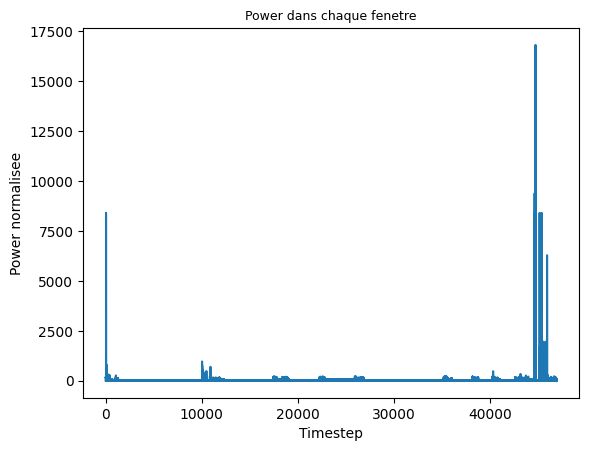

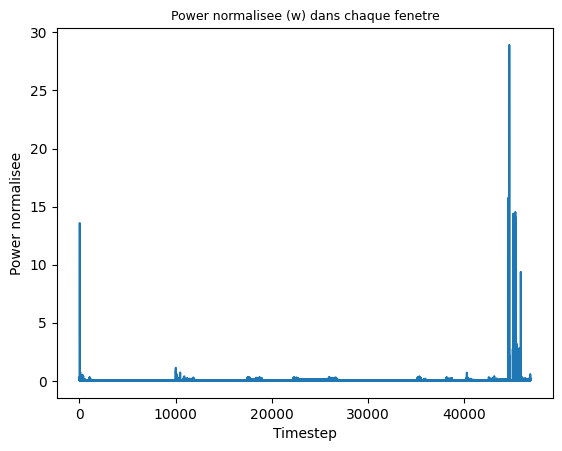

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,1.0,0.000000,0.000000,166.429993,0.000000,-166.429993,0.0,0.000000,0.000000,166.429993,0.0,1.0,3.0,3.0,55.476665,96.088402,0.288265
1,1.0,1.0,1.0,0.000000,166.429993,159.550003,-166.429993,0.000000,0.0,0.000000,166.429993,0.000000,1.0,3.0,3.0,3.0,108.659996,3.972164,0.006084
2,1.0,1.0,1.0,166.429993,159.550003,143.270004,0.000000,0.000000,0.0,166.429993,0.000000,0.000000,3.0,3.0,3.0,3.0,156.416672,9.399261,0.001392
3,1.0,1.0,1.0,159.550003,143.270004,175.880005,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0,3.0,159.566666,18.827393,0.003848
4,1.0,1.0,1.0,143.270004,175.880005,176.660004,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0,3.0,165.270004,0.450332,0.000091


In [11]:
rw_qud.shape , rw_qud.shape[0]-3
input_qud, output_qud = slide_window(dataset=rw_qud ,window_size=3)
input_qud = input_qud.squeeze()

new_qud_dataset = np.concatenate((input_qud, np.expand_dims(output_qud, axis=-1)) , axis = 1)

df_qud = pd.DataFrame(new_qud_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisons avec le coefficient de variance

df_qud['mean'] = (df_qud['p1'] + df_qud['p2'] + df_qud['p3'] ) / 3 # moyenne des valeurs power pour une window
df_qud['std_window'] = df_qud[['p2' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_qud['norm_window'] = ( df_qud['std_window']/df_qud['mean'] ) * ((df_qud[['p1' , 'p2' , 'p3']].max(axis=1) - df_qud[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_qud['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_qud['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_qud.head()

In [12]:
# quelques statistiques

df_qud.describe()

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
count,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46774.000000
mean,0.305368,0.305368,0.305368,38.012348,38.014034,38.015625,0.201070,0.201070,0.204617,-0.201070,-0.201070,-0.201070,2.716773,2.716773,2.716752,2.716688,38.014004,5.848032,0.011399
std,0.460568,0.460568,0.460568,146.826355,146.826370,146.826355,41.879669,41.879669,41.872604,41.879669,41.879669,41.879669,1.731649,1.731649,1.731676,1.731721,101.581871,102.196617,0.281140
min,0.000000,0.000000,0.000000,-10.640000,-10.640000,-10.640000,-466.839996,-466.839996,-466.839996,-8399.900391,-8399.900391,-8399.900391,0.000000,0.000000,0.000000,0.000000,-4.716667,0.000000,-0.009915
25%,0.000000,0.000000,0.000000,15.770000,15.770000,15.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.766666,0.265581,0.000013
50%,0.000000,0.000000,0.000000,17.600000,17.600000,17.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,17.526667,0.629312,0.000049
75%,1.000000,1.000000,1.000000,41.820000,41.820000,41.825001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,41.610001,1.281717,0.000167
max,1.000000,1.000000,1.000000,16816.000000,16816.000000,16816.000000,8399.900391,8399.900391,8399.900391,466.839996,466.839996,466.839996,4.000000,4.000000,4.000000,4.000000,7237.319824,9675.062500,28.924904


,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
oc1,1.000000,0.979405,0.958811,0.027165,0.026648,0.026697,-0.003455,-0.003739,-0.003440,0.003372,0.003455,0.003739,-0.898142,-0.879758,-0.861434,-0.843191,0.038790,0.018464,0.015436
oc2,0.979405,1.000000,0.979405,0.027024,0.027183,0.026664,-0.003372,-0.003455,-0.003612,0.003657,0.003372,0.003455,-0.879678,-0.898142,-0.879763,-0.861467,0.038964,0.018841,0.015795
oc3,0.958811,0.979405,1.000000,0.026901,0.027042,0.027199,-0.003657,-0.003372,-0.003328,0.003756,0.003657,0.003372,-0.861268,-0.879678,-0.898146,-0.879796,0.039094,0.019307,0.016288
p1,0.027165,0.027024,0.026901,1.000000,0.270919,0.112119,0.266103,0.018830,0.000414,0.019136,-0.266103,-0.018830,0.014420,0.007761,-0.003288,-0.003192,0.666347,0.137481,0.105586
p2,0.026648,0.027183,0.027042,0.270919,1.000000,0.270919,-0.019136,0.266103,0.018811,0.033614,0.019136,-0.266103,-0.003883,0.014402,0.007746,-0.003296,0.742857,0.615313,0.539959
p3,0.026697,0.026664,0.027199,0.112119,0.270919,1.000000,-0.033614,-0.019136,0.266126,0.000299,0.033614,0.019136,-0.010286,-0.003900,0.014388,0.007738,0.666347,0.852268,0.878890
pt01,-0.003455,-0.003372,-0.003657,0.266103,-0.019136,-0.033614,1.000000,-0.000023,-0.072227,0.000023,-1.000000,0.000023,0.032379,-0.015569,-0.035950,0.000829,0.102793,-0.014502,-0.014414
pt02,-0.003739,-0.003455,-0.003372,0.018830,0.266103,-0.019136,-0.000023,1.000000,-0.000023,0.072214,0.000023,-1.000000,0.017396,0.032379,-0.015569,-0.035949,0.128061,0.206642,0.216661
pt03,-0.003440,-0.003612,-0.003328,0.000414,0.018811,0.266126,-0.072227,-0.000023,1.000000,0.000045,0.072227,0.000023,0.003463,0.017266,0.032300,-0.015557,0.137482,0.206436,0.221802
pt11,0.003372,0.003657,0.003756,0.019136,0.033614,0.000299,0.000023,0.072214,0.000045,1.000000,-0.000023,-0.072214,0.015569,0.035950,-0.000829,-0.002938,0.025559,-0.005064,-0.009594


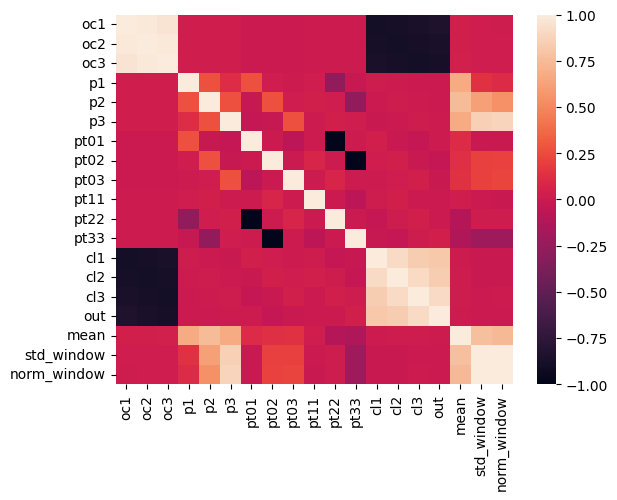

In [13]:
qud_corr = df_qud.corr()
sns.heatmap(qud_corr)
qud_corr

Dred

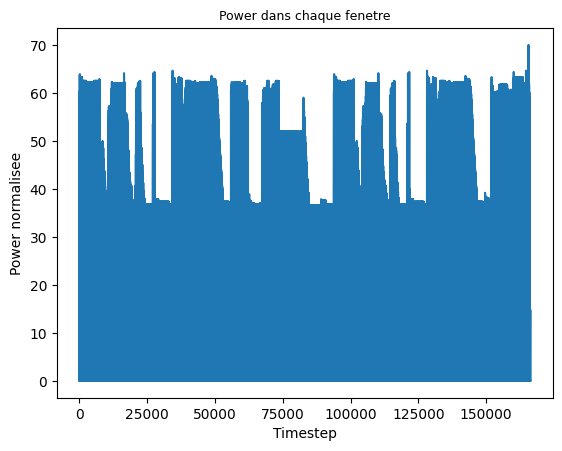

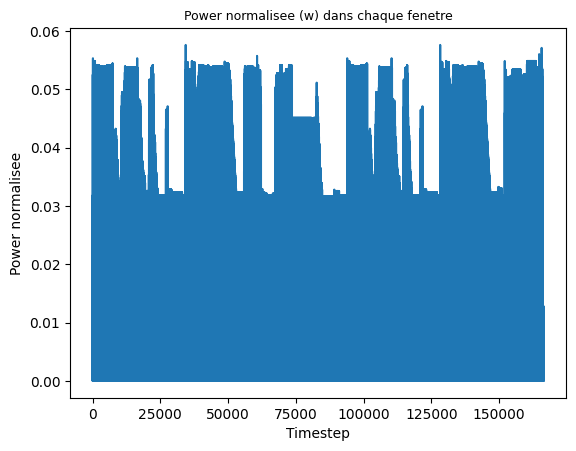

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
1,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
2,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
3,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
4,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
5,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN
7,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,NaN
8,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.537800,0.000000,0.000000,0.000000,0.0,0.0,1.0,4.0,0.000000,0.000000,NaN
9,1.0,1.0,0.0,0.000000,0.000000,1.537800,0.000000,-1.537800,0.000000,0.000000,0.000000,1.537800,0.0,1.0,4.0,0.0,0.512600,0.887849,0.002664


In [14]:
rw_dred.shape , rw_dred.shape[0]-3
input_dred, output_dred = slide_window(dataset=rw_dred ,window_size=3)
input_dred = input_dred.squeeze()

new_dred_dataset = np.concatenate((input_dred, np.expand_dims(output_dred, axis=-1)) , axis = 1)

df_dred = pd.DataFrame(new_dred_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisaons avec le coefficient de variance

df_dred['mean'] = (df_dred['p1'] + df_dred['p2'] + df_dred['p3'] ) / 3 # moyenne des valeurs power pour une window
df_dred['std_window'] = df_dred[['p2' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_dred['norm_window'] = ( df_dred['std_window']/df_dred['mean'] ) * ((df_dred[['p1' , 'p2' , 'p3']].max(axis=1) - df_dred[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_dred['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_dred['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_dred.head(50)

In [15]:
# quelques statistiques

df_dred.describe()

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
count,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,164653.000000
mean,0.498744,0.498738,0.498738,48.256683,48.256683,48.256683,-0.000141,-0.000141,-0.000141,0.000141,0.000141,0.000141,2.596423,2.596423,2.596423,2.596423,48.256683,1.158520,0.001728
std,0.500000,0.500000,0.500000,15.973123,15.973123,15.973123,10.272110,10.272110,10.272110,10.272110,10.272110,10.272110,1.694745,1.694745,1.694745,1.694745,14.830507,5.817472,0.008777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-65.004997,-65.004997,-65.004997,-63.869999,-63.869999,-63.869999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,37.330002,37.330002,37.330002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.330002,0.000000,0.000000
50%,0.000000,0.000000,0.000000,52.070000,52.070000,52.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,52.069996,0.000000,0.000000
75%,1.000000,1.000000,1.000000,61.990002,61.990002,61.990002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,61.990002,0.000000,0.000000
max,1.000000,1.000000,1.000000,70.029999,70.029999,70.029999,63.869999,63.869999,63.869999,65.004997,65.004997,65.004997,4.000000,4.000000,4.000000,4.000000,69.775337,37.530655,0.057598


,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166345,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
166346,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
166347,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
166348,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


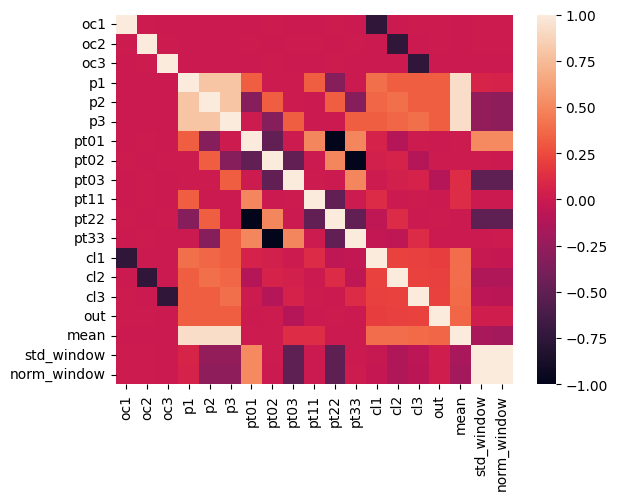

In [16]:
dred_corr = df_dred.corr()
sns.heatmap(dred_corr)
df_dred

Models

In [17]:
# Separation en train et test

scaler = StandardScaler()
# dred
dred_feature = df_dred.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
dred_target  = df_dred.iloc[ : , 1:-3 ].out

dred_features_train = dred_feature.iloc[ : int(dred_feature.shape[0]*0.8 ) , : ]
dred_features_test  = dred_feature.iloc[ int(dred_feature.shape[0]*0.8 ) : , : ]  

dred_target_train = dred_target.iloc[ : int(dred_feature.shape[0]*0.8 ) ]
dred_target_test  = dred_target.iloc[ int(dred_feature.shape[0]*0.8 ) : ]  

# dred_features_train = scaler.fit_transform(dred_features_train)
# dred_features_test  = scaler.fit_transform(dred_features_test) 


# qud
qud_feature = df_qud.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
qud_target  = df_qud.iloc[ : , 1:-3 ].out

qud_features_train = qud_feature.iloc[ : int(qud_feature.shape[0]*0.8 ) , : ]
qud_features_test  = qud_feature.iloc[ int(qud_feature.shape[0]*0.8 ) : , : ]  

qud_target_train = qud_target.iloc[ : int(qud_feature.shape[0]*0.8 ) ]
qud_target_test  = qud_target.iloc[ int(qud_feature.shape[0]*0.8 ) : ]  

# qud_features_train = scaler.fit_transform(qud_features_train)
# qud_features_test  = scaler.fit_transform(qud_features_test)

In [20]:
# qud

xgb = XGBClassifier()


xgb.fit(qud_features_train, qud_target_train)
yhat = xgb.predict(qud_features_test)

print(f"Les scores de chaque classe: \n{f1_score(qud_target_test, yhat, average = None)}")

print()
macro = f1_score(qud_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{macro}")

Les scores de chaque classe: 
[0.95946626 0.99038462 0.99056604 0.85768501 0.98150134]

Les scores de ENSEMBLE classe: 
0.9559206533875264


In [21]:
# dred

xgb = XGBClassifier()


xgb.fit(dred_features_train, dred_target_train)
yhat = xgb.predict(dred_features_test)


print(f"Les scores de chaque classe: \n{f1_score(dred_target_test, yhat, average = None)}")

print()
macro = f1_score(dred_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{macro}")

Les scores de chaque classe: 
[0.56504791 0.9939302  0.03221083 0.46581367 0.50153646]

Les scores de ENSEMBLE classe: 
0.5117078150410409


### Normalisation avec le stateful pour le ML

In [22]:
# drop de la colonne de la "power normalized"

dred_dropped = rw_dred.drop('Pn', axis=1)
qud_dropped  = rw_qud.drop('Pn', axis=1)

print(dred_dropped.head())
print()
print(qud_dropped.head())

   occupancy    P  P+t1  P-t1  class_state
0          1  0.0   0.0   0.0            0
1          1  0.0   0.0   0.0            0
2          0  0.0   0.0   0.0            0
3          1  0.0   0.0   0.0            0
4          0  0.0   0.0   0.0            0

   occupancy       P    P+t1    P-t1  class_state
0          1    0.00    0.00    0.00            0
1          1    0.00 -166.43    0.00            1
2          1  166.43    0.00  166.43            3
3          1  159.55    0.00    0.00            3
4          1  143.27    0.00    0.00            3


In [23]:
processor = DataProcessing(qud_dropped)
X_qud , y_qud = processor.processing()

Streaming output truncated to the last 5000 lines.
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[  1.   103.99   0.     0.  ]
 [  1.    36.96   0.     0.  ]
 [  1.   109.73   0.     0.  ]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[1. 1. 1.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[  1.    36.96   0.     0.  ]
 [  1.   109.73   0.     0.  ]
 [  1.    78.63  78.63   0.  ]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[1. 1. 1.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[  1.   109.73   0.     0.  ]
 [  1.    78.63  78.63   0.  ]
 [  1.     0.     0.   -78.63]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[1. 1. 1.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0.

In [24]:
processor = DataProcessing(dred_dropped)
X_dred , y_dred = processor.processing()

Streaming output truncated to the last 5000 lines.
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[ 0.   14.81  0.    0.  ]
 [ 0.   14.81  0.    0.  ]
 [ 0.   14.81  0.    0.  ]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[ 0.   14.81  0.    0.  ]
 [ 0.   14.81  0.    0.  ]
 [ 0.   14.81  0.    0.  ]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
%%%%%%%%%%%%%%%%%%%%%%%%%  FIN  %%%%%%%%%%%%


Les valeurs de la fenetre -->
[[ 0.   14.81  0.    0.  ]
 [ 0.   14.81  0.    0.  ]
 [ 1.   14.81  0.    0.  ]]

%%%%%%%%%%%%%%%%%%%%%  DEBUT  %%%%%%%%%%%%%%%%%%%%

[0. 0. 1.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

Models

In [25]:
# qud

qud_features_train_sf = X_qud[ : int(X_qud.shape[0]*0.8 ) , : ]
qud_features_test_sf  = X_qud[ int(X_qud.shape[0]*0.8 ) : , : ]  

qud_target_train_sf = y_qud[ : int(y_qud.shape[0]*0.8 ) ]
qud_target_test_sf  = y_qud[ int(y_qud.shape[0]*0.8 ) : ]  

# print(qud_features_train_sf)
# print()
# print(qud_target_train_sf)


xgb_sf = XGBClassifier()


xgb.fit(qud_features_train_sf, qud_target_train_sf)
yhat = xgb.predict(qud_features_test_sf)


print(f"Les scores de chaque classe: \n{f1_score(qud_target_test_sf, yhat, average = None)}")

print()
macro = f1_score(qud_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{macro}")

Les scores de chaque classe: 
[0.89800114 0.         0.         0.         0.89916877]

Les scores de ENSEMBLE classe: 
0.35600490954223474


In [26]:
# dred
 
dred_features_train_sf = X_dred[ : int(X_dred.shape[0]*0.8 ) , : ]
dred_features_test_sf  = X_dred[ int(X_dred.shape[0]*0.8 ) : , : ]  

dred_target_train_sf = y_dred[ : int(y_dred.shape[0]*0.8 ) ]
dred_target_test_sf  = y_dred[ int(y_dred.shape[0]*0.8 ) : ]  

# print(dred_features_test_sf.shape)
# print()
# print(dred_target_test_sf.shape)



xgb_sf = XGBClassifier()


xgb.fit(dred_features_train_sf, dred_target_train_sf)
yhat = xgb.predict(dred_features_test_sf)


print(f"Les scores de chaque classe: \n{f1_score(dred_target_test_sf, yhat, average = None)}")

print()
# print(dred_target_test.shape)
# print(yhat.shape)
macro = f1_score(dred_target_test_sf, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{macro}")

Les scores de chaque classe: 
[0.48722562 0.         0.         0.         0.97120177]

Les scores de ENSEMBLE classe: 
0.2916854785851028


Sauvegarde du meilleur model en ML

In [ ]:
# avec pickle

filename = '/Models/best2_model.sav'
pickle.dump(xgb, open(filename, 'wb'))

# avec joblib

filename = 'Models/best1_model.sav'
joblib.dump(xgb, filename)


### Deep Machine Learning

In [28]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model = create_model( 
    input_shape = (3, 4), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 4)]            0         
                                                                 
 dense_1 (Dense)             (None, 3, 256)            1280      
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 659,461
Trainable params: 659,461
Non-trainable

In [29]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [get_f1, 'accuracy']
)

In [30]:
# donnees

rw_dred_cleaned = rw_dred.drop(['Pn'] , axis=1)
rw_qud_cleaned  = rw_qud.drop(['Pn'] , axis=1)

## dred
dred_train = rw_dred_cleaned[:int(df_dred.shape[0]*0.8)]
dred_test = rw_dred_cleaned[int(df_dred.shape[0]*0.8):]
print(dred_train.head())

## qud
qud_train = rw_qud_cleaned[:int(df_qud.shape[0]*0.8)]
qud_test = rw_qud_cleaned[int(df_qud.shape[0]*0.8):]
print(qud_train.head())

   occupancy    P  P+t1  P-t1  class_state
0          1  0.0   0.0   0.0            0
1          1  0.0   0.0   0.0            0
2          0  0.0   0.0   0.0            0
3          1  0.0   0.0   0.0            0
4          0  0.0   0.0   0.0            0
   occupancy       P    P+t1    P-t1  class_state
0          1    0.00    0.00    0.00            0
1          1    0.00 -166.43    0.00            1
2          1  166.43    0.00  166.43            3
3          1  159.55    0.00    0.00            3
4          1  143.27    0.00    0.00            3


In [34]:
#dred

generateur_train = Generateur(dred_train, window_size=3, batch_size=256)
generateur_test = Generateur(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
dred_hist = model.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 20s 38ms/step - loss: 0.5549 - get_f1: 0.7734 - accuracy: 0.7759 - val_loss: 0.6231 - val_get_f1: 0.6350 - val_accuracy: 0.6350
Epoch 2/10
519/519 [==============================] - 22s 42ms/step - loss: 0.5450 - get_f1: 0.7714 - accuracy: 0.7714 - val_loss: 0.6418 - val_get_f1: 0.6350 - val_accuracy: 0.6350
Epoch 3/10
519/519 [==============================] - 20s 38ms/step - loss: 0.5439 - get_f1: 0.7714 - accuracy: 0.7714 - val_loss: 0.6201 - val_get_f1: 0.6350 - val_accuracy: 0.6350
Epoch 4/10
519/519 [==============================] - 23s 44ms/step - loss: 0.5430 - get_f1: 0.7714 - accuracy: 0.7714 - val_loss: 0.6142 - val_get_f1: 0.6350 - val_accuracy: 0.6350
Epoch 5/10
519/519 [==============================] - 20s 38ms/step - loss: 0.5427 - get_f1: 0.7714 - accuracy: 0.7714 - val_loss: 0.6207 - val_get_f1: 0.6350 - val_accuracy: 0.6350
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.5463 - get_f

In [33]:
#qud

generateur_train = Generateur(qud_train, window_size=3, batch_size=256)
generateur_test = Generateur(qud_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
qud_hist = model.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
146/146 [==============================] - 10s 66ms/step - loss: 0.5723 - get_f1: 0.8557 - accuracy: 0.8557 - val_loss: 0.5654 - val_get_f1: 0.8557 - val_accuracy: 0.8557
Epoch 2/10
146/146 [==============================] - 9s 64ms/step - loss: 0.5714 - get_f1: 0.8557 - accuracy: 0.8557 - val_loss: 0.5662 - val_get_f1: 0.8557 - val_accuracy: 0.8557
Epoch 3/10
146/146 [==============================] - 8s 56ms/step - loss: 0.5732 - get_f1: 0.8557 - accuracy: 0.8557 - val_loss: 0.5634 - val_get_f1: 0.8557 - val_accuracy: 0.8557
Epoch 4/10
146/146 [==============================] - 9s 65ms/step - loss: 0.5664 - get_f1: 0.8557 - accuracy: 0.8557 - val_loss: 0.5833 - val_get_f1: 0.8557 - val_accuracy: 0.8557
Epoch 5/10
146/146 [==============================] - 9s 64ms/step - loss: 0.5739 - get_f1: 0.8557 - accuracy: 0.8557 - val_loss: 0.5661 - val_get_f1: 0.8557 - val_accuracy: 0.8557
Epoch 6/10
146/146 [==============================] - 8s 54ms/step - loss: 0.5664 - get_f1: 0.